In [324]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
sns.set_style("whitegrid")

plt.rc("figure", figsize=(11,6))
plt.rc("font", size=13)

print("Pandas Version: " + pd.__version__)
print("Numpy Version: " + np.__version__)
print("Seaborn Version: " + sns.__version__)

Pandas Version: 1.2.4
Numpy Version: 1.18.5
Seaborn Version: 0.11.1


In [109]:
df_trips = pd.read_csv("../data/clean/trips.csv", parse_dates=["date_from", "date_until"])
df_trips.head(3)

,bike_id,user_id,date_from,date_until,start_station_name,start_station_id,end_station_name,end_station_id,booked_via,duration_in_min,distance_in_km,speed_in_kmh,time_since_last_checkout
0,119911,341973A96CDE0DF9792F6C844622735AE4216EBF,2014-01-01 00:02:51,2014-01-01 00:20:04,Enckeplatz / Hütten,131887,Königstraße / Struenseestraße,131650,Terminal HH_8 (-2624-),18,2.364129,7.880431,NaN
1,118994,665D79F269FA03F84FC61F3A7F7B078D7392EC0E,2014-01-01 00:07:45,2014-01-01 00:10:48,Isestraße / Hoheluftbrücke,140804,Isestraße / Hoheluftbrücke,140804,Terminal HH_63 (-2241-),4,0.000000,0.000000,NaN
2,143660,B46B52FDC494E46849DB84BF84F0B99C78358E59,2014-01-01 00:09:55,2014-01-01 00:26:20,Schulterblatt/Eifflerstraße,131648,Schulterblatt/Eifflerstraße,131648,Android SRH,17,0.000000,0.000000,NaN


In [184]:
weather = pd.read_csv("../data/clean/weather.csv", parse_dates=["datetime"])
weather.set_index("datetime", inplace=True)
weather.head(3)

,precip_intensity,precip_probability,precip_type,temperature,humidity,wind_speed,wind_bearing,uv_index,visibility
datetime,,,,,,,,,
2014-01-01 00:00:00,0.0,0.0,none,1.93,0.81,3.91,161.0,0,9.988
2014-01-01 01:00:00,0.0,0.0,none,1.94,0.85,4.56,140.0,0,6.004
2014-01-01 02:00:00,0.0,0.0,none,1.81,0.85,4.12,143.0,0,9.988


In [185]:
trips = df_trips.set_index("date_from").sort_index()

In [186]:
trips.index.min()

Timestamp('2014-01-01 00:02:51')

In [187]:
trips.index.max()

Timestamp('2017-05-16 08:08:09')

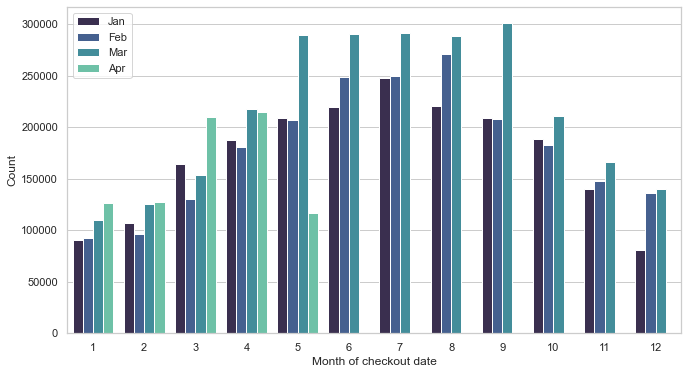

In [225]:
# Trips by month and by year
ax = sns.countplot(
    x=trips.index.month,
    hue=trips.index.year,
    data=trips,
    palette="mako"
)
ax.set(xlabel="Month of checkout date", ylabel="Count")
plt.legend(labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Nov", "Dec"])
plt.savefig("figures/count_trips_per_month.png", bbox_inches="tight")
plt.show()

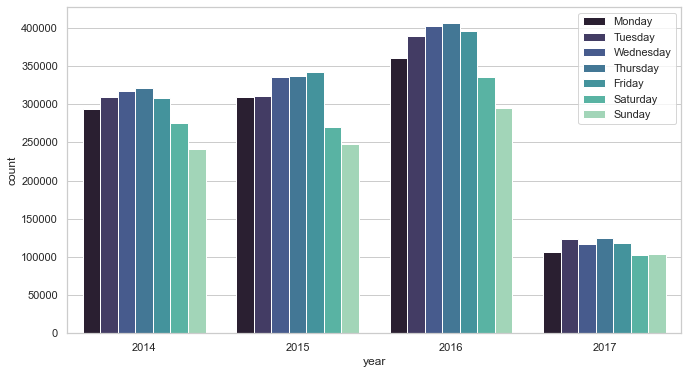

In [224]:
ax = sns.countplot(
    x=trips.index.year,
    hue=trips.index.weekday,
    data=trips,
    palette="mako"
)
ax.set(xlabel="year", ylabel="count")
plt.legend(labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.savefig("figures/count_trips_per_weekday.png", bbox_inches="tight")
plt.show()

In [190]:
grouped_by_year_and_month = trips.groupby([trips.index.year, trips.index.month])

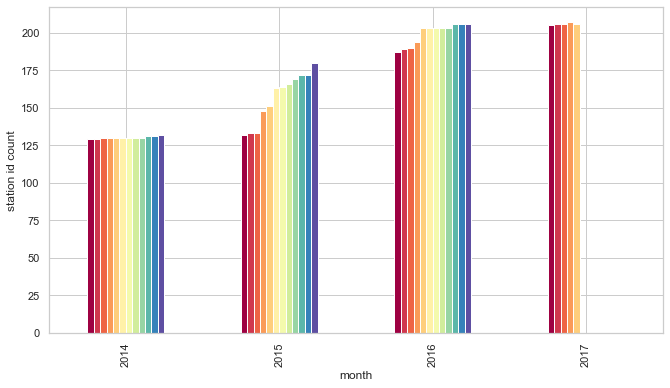

In [231]:
stations_per_month = pd.DataFrame(grouped_by_year_and_month.start_station_name.nunique()).unstack()
stations_per_month.plot(kind="bar", legend=False, cmap="Spectral")
plt.xlabel("month")
plt.ylabel("station id count")
plt.savefig("figures/count_unique_stations_per_months.png", bbox_inches="tight")
plt.show()

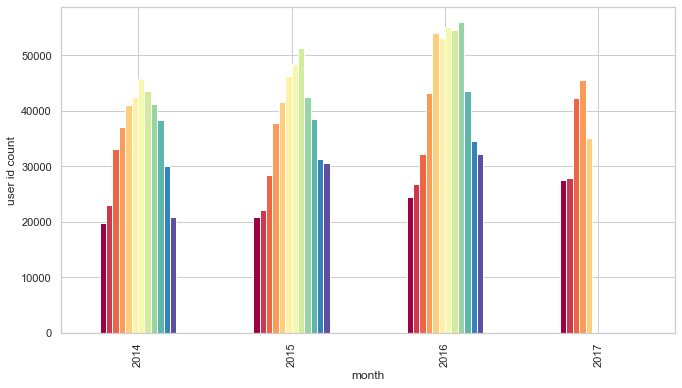

In [232]:
users_per_month = pd.DataFrame(grouped_by_year_and_month.user_id.nunique()).unstack()
users_per_month.plot(kind="bar", legend=False, cmap="Spectral")
plt.xlabel("month")
plt.ylabel("user id count")
plt.savefig("figures/count_unique_users_per_months.png", bbox_inches="tight")
plt.show()

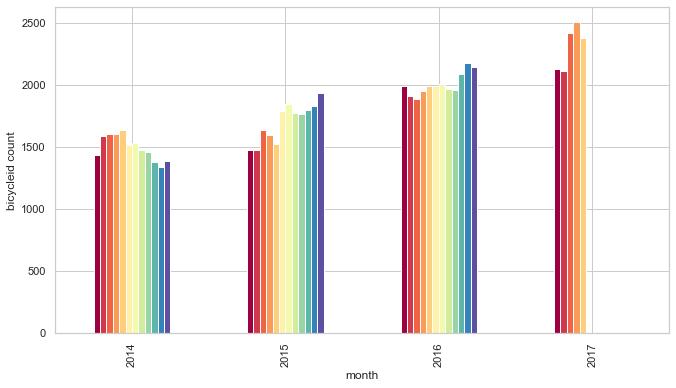

In [233]:
bikes_per_month = pd.DataFrame(grouped_by_year_and_month.bike_id.nunique()).unstack()
bikes_per_month.plot(kind="bar", legend=False, cmap="Spectral")
plt.xlabel("month")
plt.ylabel("bicycleid count")
plt.savefig("figures/count_unique_bikes_per_months.png", bbox_inches="tight")
plt.show()

## Explore trend and seasonality

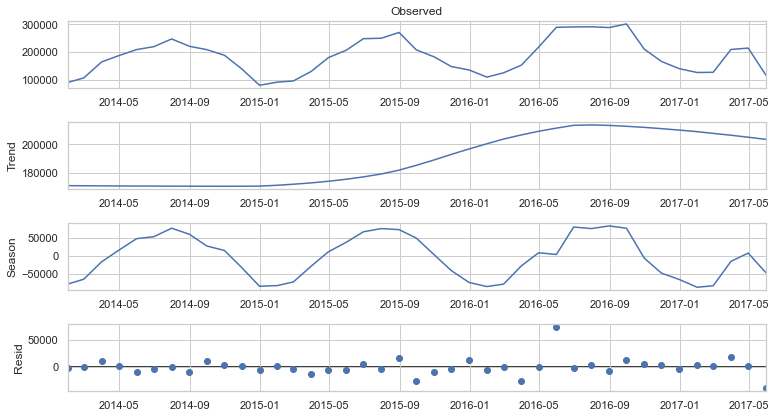

In [234]:
monthly_check_outs = trips[["bike_id"]].resample("M").count().rename(columns={"bike_id": "count"})
STL(monthly_check_outs).fit().plot()
plt.savefig("figures/stl_months.png", bbox_inches="tight")
plt.show()

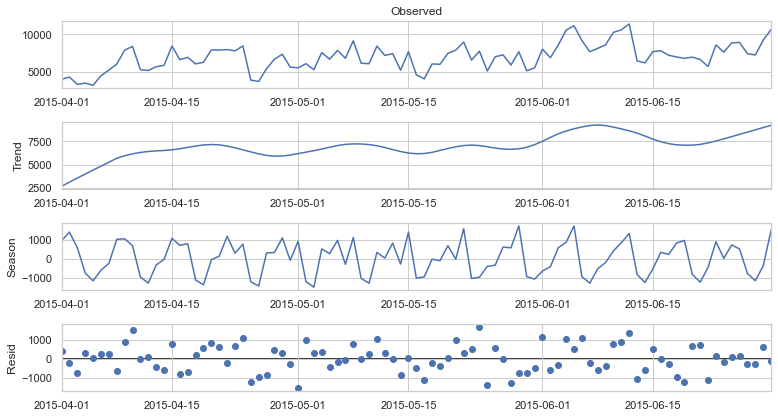

In [235]:
daily_check_outs = trips[pd.Timestamp("2015-04-01"):pd.Timestamp("2015-06-30 23:59:00")]
daily_check_outs = daily_check_outs[["bike_id"]].resample("D").count().rename(columns={"bike_id": "count"})
STL(daily_check_outs).fit().plot()
plt.savefig("figures/stl_days.png", bbox_inches="tight")
plt.show()

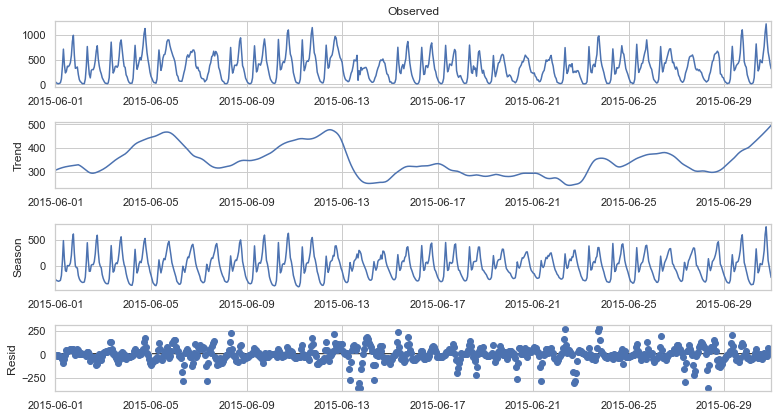

In [236]:
hourly_check_outs = trips[pd.Timestamp("2015-06-01"):pd.Timestamp("2015-06-30 23:59:00")]
hourly_check_outs = hourly_check_outs[["bike_id"]].resample("H").count().rename(columns={"bike_id": "count"})
STL(hourly_check_outs).fit().plot()
plt.savefig("figures/stl_hours.png", bbox_inches="tight")
plt.show()

## Plot distribution of values

In [322]:
def display_distribution(attribute, label, bins):
    values = trips[[attribute]]
    plt.figure(figsize=(16,5))
    plt.hist(values, alpha=0.7, bins=bins)
    plt.xlabel(label)
    plt.ylabel("count")
    plt.savefig("figures/trips_hist_%s"%attribute, bbox_inches="tight")
    plt.show()

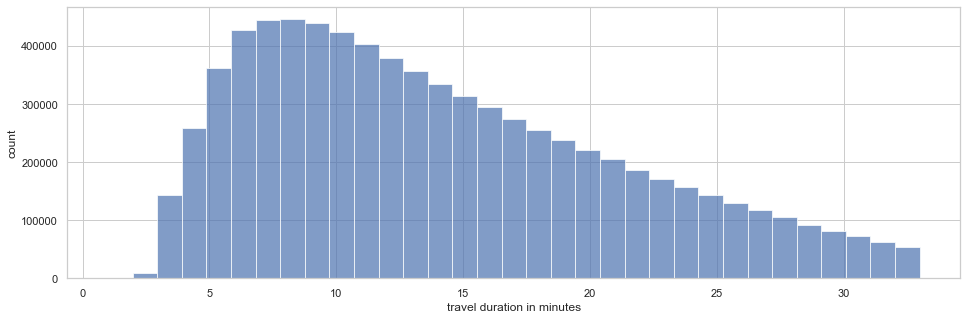

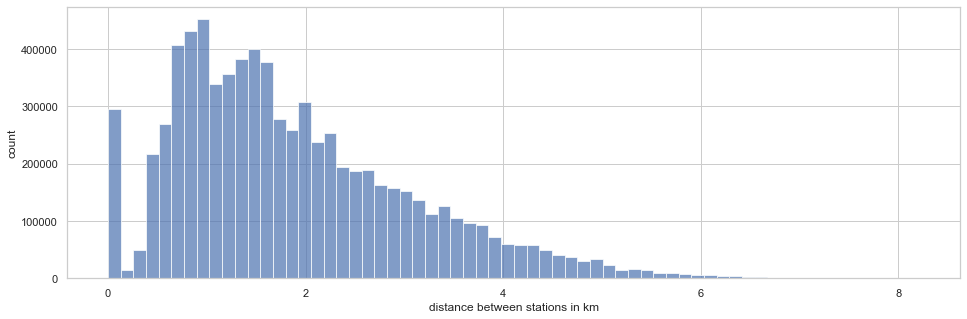

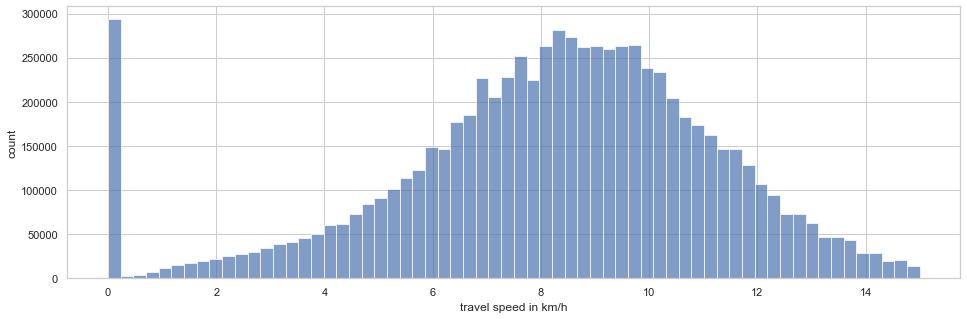

In [325]:
display_distribution("duration_in_min", label="travel duration in minutes", bins=len(pd.unique(trips.duration_in_min)))
display_distribution("distance_in_km", label="distance between stations in km", bins=64)
display_distribution("speed_in_kmh", label="travel speed in km/h", bins=64)

## Plot count of "technical income channel" occurrence

In [239]:
booked_via = trips[["booked_via"]].copy()
booked_via.loc[booked_via.booked_via.str.startswith("Terminal"), "booked_via"] = "Terminal"
booked_via.loc[booked_via.booked_via.str.startswith("terminal"), "booked_via"] = "Terminal"
booked_via.loc[booked_via.booked_via.str.startswith("Techniker"), "booked_via"] = "Techniker"
booked_via.loc[booked_via.booked_via.str.startswith("Starenkasten"), "booked_via"] = "Starenkasten"

rarely_used_booked_via = [
    'Android',
    'BlackBerry',
    'Windows',
    'iPhone KON',
    'CaB - Mobility Map',
    'LIDL-BIKE',
    'Android KON',
    'Starenkasten'
]

booked_via["booked_via"] = booked_via[["booked_via"]].replace(rarely_used_booked_via, "Other")

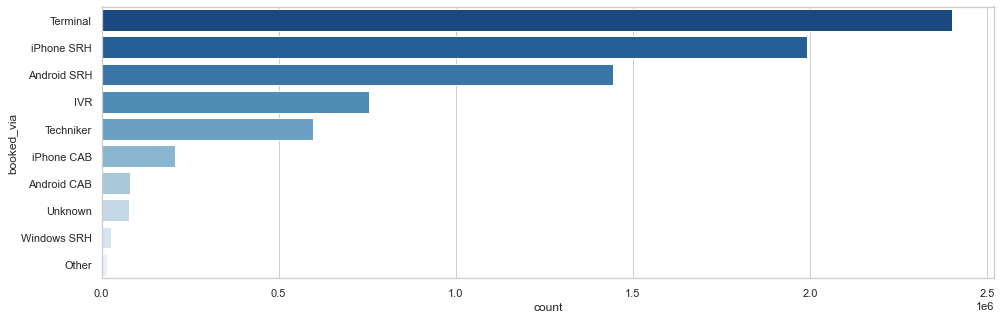

In [240]:
plt.figure(figsize=(16,5))
ax = sns.countplot(
    data=booked_via,
    y="booked_via",
    order=booked_via.booked_via.value_counts().index,
    palette="Blues_r"
)
ax.set(xlabel="count", ylabel="booked_via")
plt.savefig("figures/trips_hist_booked_via.png", bbox_inches="tight")
plt.show()

## Plot trip count per day, week and month

In [241]:
full_day_start_date = "2014-01-07" # first day
full_day_end_date = "2017-05-14 23:59:59" # last complete day
daily_trips = trips[
    pd.Timestamp(full_day_start_date):pd.Timestamp(full_day_end_date)
].resample("D")[["bike_id"]].count().rename(columns={"bike_id": "count"})

full_week_start_date = "2014-01-07" # first Sunday morning
full_week_end_date = "2017-05-14 23:59:59" # last Monday evening
weekly_mean = daily_trips[
    pd.Timestamp(full_week_start_date):pd.Timestamp(full_week_end_date)
].resample("W").mean()

full_month_start_date = "2014-01-01" # first day
full_month_end_date = "2017-04-30 23:59:59" # last day of last complete month
monthly_mean = daily_trips[
    pd.Timestamp(full_month_start_date):pd.Timestamp(full_month_end_date)
].resample("M").mean()

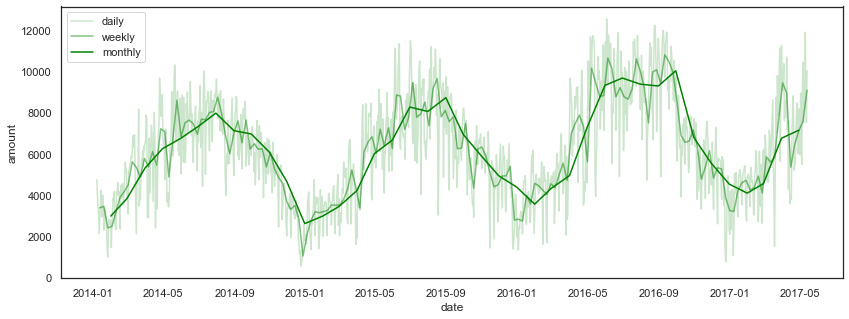

In [295]:
plt.rc("figure", figsize=(14,5))
sns.set_style("white")

plt.plot(daily_trips, label="daily", color="green", alpha=0.2)
plt.plot(weekly_mean, label="weekly", color="green", alpha=0.5)
plt.plot(monthly_mean, label="monthly", color="green")
plt.xlabel("date")
plt.ylabel("amount")
plt.legend(loc="upper left")
plt.savefig("figures/trips_mean_values.png", bbox_inches="tight")
plt.show()

sns.set_style("whitegrid")

## Count yearly trip amount

In [296]:
full_year_start_date = "2014-01-01" # first day
full_year_end_date = "2016-12-12 23:59:59" # last day of last complete year
yearly_count = trips[
    pd.Timestamp(full_year_start_date):pd.Timestamp(full_year_end_date)
].resample("Y")[["bike_id"]].count()

yearly_count

,bike_id
date_from,
2014-12-31,2064964
2015-12-31,2149737
2016-12-31,2506183


## Plot correlation with weather data

In [297]:
# Remove the last trips that do not form a complete week
trips = trips.loc["2014-01-01":"2017-05-14"]

In [298]:
weekly_weather = weather.resample("W").mean()
weekly_trips_count = trips[["bike_id"]].resample("W").count().rename(columns={"bike_id": "trip_count"})

weekly = weekly_weather.merge(weekly_trips_count, left_index=True, right_index=True)
weekly

,precip_intensity,precip_probability,temperature,humidity,wind_speed,wind_bearing,uv_index,visibility,trip_count
2014-01-05,0.013578,0.041000,5.441833,0.859000,4.138833,179.083333,0.000000,9.838858,13357
2014-01-12,0.044758,0.072381,6.999286,0.861131,5.395536,228.982143,0.000000,9.719101,23329
2014-01-19,0.030308,0.047143,3.906964,0.933155,3.653869,133.398810,0.035714,7.280048,24101
2014-01-26,0.000279,0.001488,-4.939464,0.843988,4.517500,102.607143,0.083333,7.852720,16757
2014-02-02,0.009192,0.018333,-1.639107,0.864167,4.060714,128.422619,0.130952,7.718012,17274
...,...,...,...,...,...,...,...,...,...
2017-04-16,0.071538,0.091845,7.869583,0.749821,3.919405,265.982143,1.119048,9.730935,37436
2017-04-23,0.023692,0.040417,5.781012,0.678512,2.986429,226.461310,1.250000,9.771304,45429
2017-04-30,0.042130,0.046964,6.534286,0.687202,2.587500,223.077381,1.410714,9.978899,49881
2017-05-07,0.037746,0.043988,10.089524,0.707440,3.171250,88.273810,1.476190,9.553851,53036


In [299]:
weekly_scaled = weekly.copy()
weekly_scaled[weekly_scaled.columns] = StandardScaler().fit_transform(weekly_scaled[weekly_scaled.columns])
weekly_scaled

,precip_intensity,precip_probability,temperature,humidity,wind_speed,wind_bearing,uv_index,visibility,trip_count
2014-01-05,-0.656009,0.201673,-0.746555,0.877174,0.451449,-0.298233,-1.174235,0.795626,-1.973006
2014-01-12,0.307141,1.301493,-0.496261,0.902046,1.457330,0.771091,-1.174235,0.682331,-1.312600
2014-01-19,-0.139226,0.416964,-0.993220,1.742704,0.063277,-1.277245,-1.118971,-1.625121,-1.261474
2014-01-26,-1.066784,-1.183115,-2.414909,0.701956,0.754538,-1.937106,-1.045287,-1.083348,-1.747838
2014-02-02,-0.791484,-0.592734,-1.884517,0.937479,0.388921,-1.383884,-0.971603,-1.210788,-1.713599
...,...,...,...,...,...,...,...,...,...
2017-04-16,1.134347,1.983665,-0.356397,-0.397152,0.275815,1.563996,0.557345,0.693525,-0.378350
2017-04-23,-0.343591,0.181229,-0.692047,-1.229473,-0.470951,0.717070,0.759976,0.731716,0.150995
2017-04-30,0.225965,0.410706,-0.570990,-1.128038,-0.790259,0.644553,1.008661,0.928111,0.445833
2017-05-07,0.090531,0.306398,0.000364,-0.891820,-0.323018,-2.244267,1.109977,0.525997,0.654776


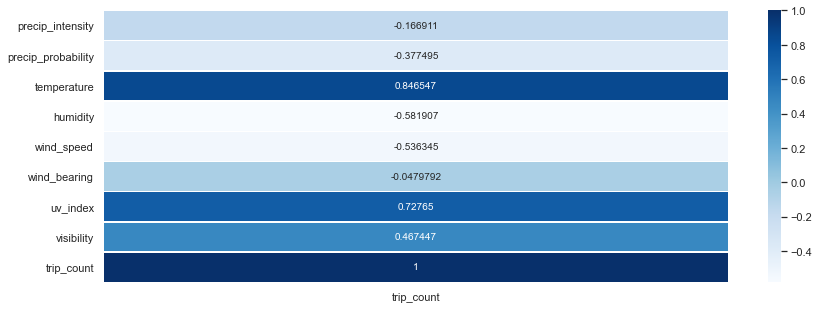

In [300]:
trip_count_corr = weekly_scaled.corr()[["trip_count"]]
sns.heatmap(data=trip_count_corr, annot=True, annot_kws={"size": 10}, fmt="g", linewidths=.5, cmap="Blues")
plt.show()

<Figure size 1152x576 with 0 Axes>

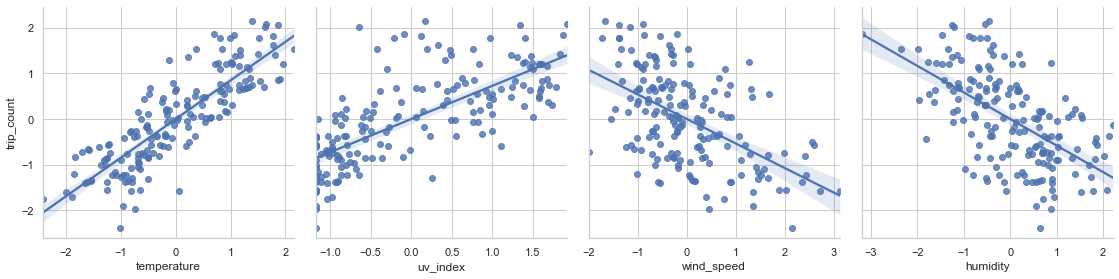

In [301]:
plt.figure(figsize=(16,8))
x_vars = ["temperature", "uv_index", "wind_speed", "humidity"]
y_vars = ["trip_count"]
g = sns.PairGrid(weekly_scaled, x_vars = x_vars, y_vars=y_vars, height=4)
g.map_offdiag(sns.regplot)
plt.savefig("figures/trips_weather_corr_scatter.png", bbox_inches="tight")
plt.show()

<Figure size 1152x576 with 0 Axes>

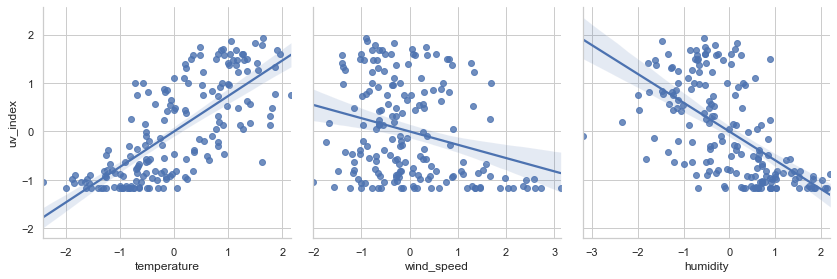

In [311]:
plt.figure(figsize=(16,8))
x_vars = ["temperature", "wind_speed", "humidity"]
y_vars = ["uv_index"]
g = sns.PairGrid(weekly_scaled, x_vars = x_vars, y_vars=y_vars, height=4)
g.map_offdiag(sns.regplot)

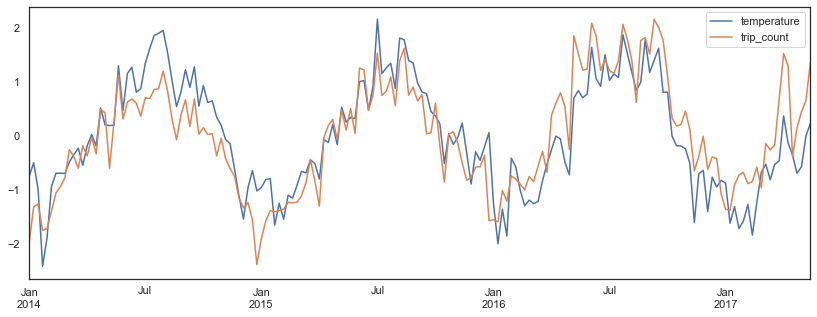

In [312]:
sns.set_style("white")

weekly_scaled.temperature.plot()
weekly_scaled.trip_count.plot()
plt.legend()
plt.savefig("figures/trips_temperature.png", bbox_inches="tight")
plt.show()

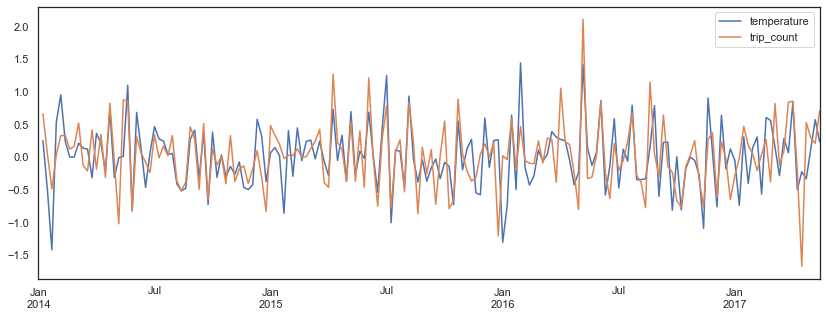

In [313]:
weekly_scaled.diff().temperature.plot()
weekly_scaled.diff().trip_count.plot()
plt.legend()

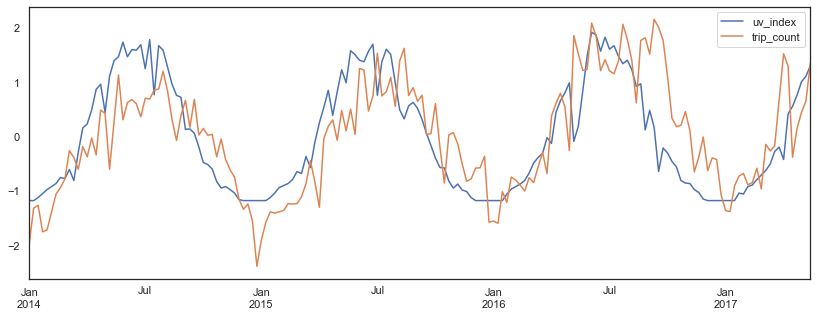

In [314]:
weekly_scaled.uv_index.plot()
weekly_scaled.trip_count.plot()
plt.legend()
plt.savefig("figures/trips_uv_index.png", bbox_inches="tight")
plt.show()

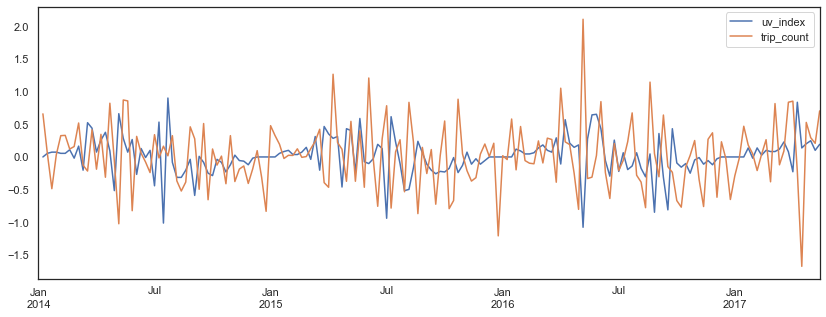

In [315]:
weekly_scaled.diff().uv_index.plot()
weekly_scaled.diff().trip_count.plot()
plt.legend()

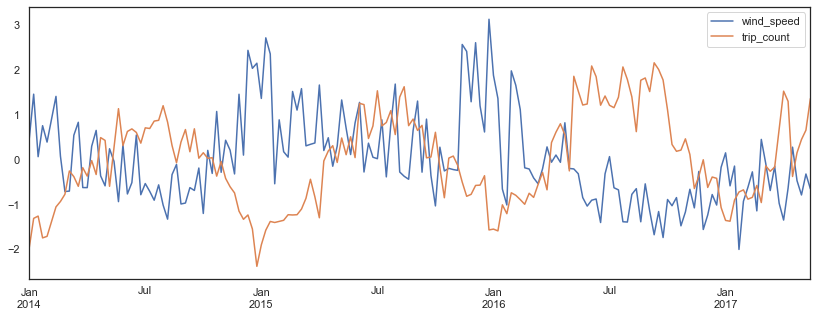

In [316]:
weekly_scaled.wind_speed.plot()
weekly_scaled.trip_count.plot()
plt.legend()
plt.savefig("figures/trips_wind_speed.png", bbox_inches="tight")
plt.show()

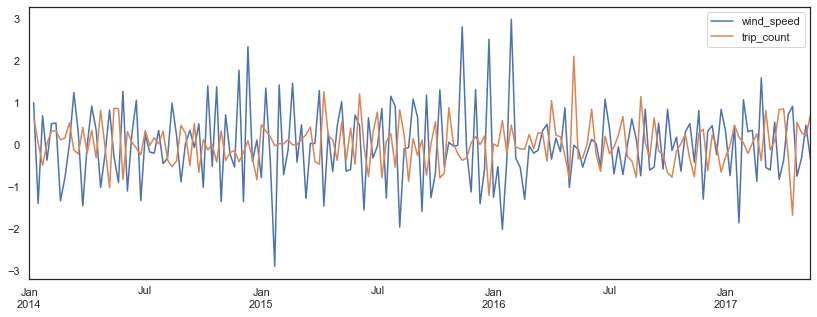

In [317]:
weekly_scaled.diff().wind_speed.plot()
weekly_scaled.diff().trip_count.plot()
plt.legend()

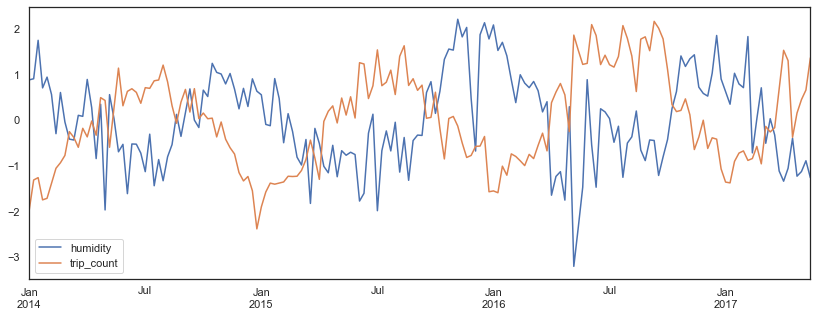

In [318]:
weekly_scaled.humidity.plot()
weekly_scaled.trip_count.plot()
plt.legend()
plt.savefig("figures/trips_humidity.png", bbox_inches="tight")
plt.show()

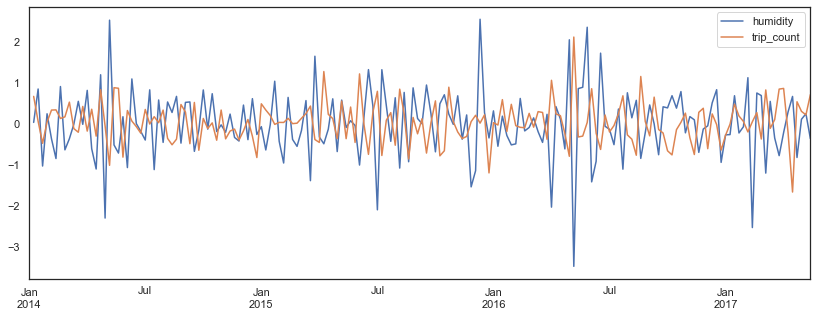

In [319]:
weekly_scaled.diff().humidity.plot()
weekly_scaled.diff().trip_count.plot()
plt.legend()